In [1]:
import json
import math
import os
import re
import random
from operator import itemgetter
from pathlib import Path
from pprint import pprint
import pandas as pd
#!pip install --upgrade spacy
import spacy
from spacy.util import compounding, minibatch
from spacy import displacy
# Uncomment if you want Spacy to use GPU for training. Note - this will use transformer architecture
spacy.require_gpu()

# import requirements for converting the dataframe to Spacy Docs
from collections import defaultdict
from typing import List
from spacy.language import Language
from spacy.tokens import Doc, DocBin, Span
from spacy.util import filter_spans

In [4]:
nlp = spacy.load("/root/Projects/Atlomy/git/greCy_ATLOMY/training/transformer_mostfiles/assembled/model-best")

# Load Data Table

In [5]:
FILE_PATH = "../assets/NER_assets/Ancient_Words.csv"
# read csv file
df = pd.read_csv(FILE_PATH)

# Preprocess Text

In [6]:
# rename columns to fit code
df.rename(columns = {'Word':'Keyword', 'Category Types':'Label'}, inplace = True)
# If a cell is empty (NaN), Fill it with the value in its parallel "Early" column
for row in df:
    df['Quote'].fillna(df['Early Quote'], inplace=True)
    df['Word Before'].fillna(df['Early Word Before'], inplace=True)
    df['Word After'].fillna(df['Early Word After'], inplace=True)
    df['Label'].fillna(df['Early Category Type'], inplace=True)
# remove rows with no Keyword
df = df.dropna(subset=['Keyword'])
# Remove any row that isn't Greek
pat = '[ء-ي]+'
#df.Keyword.str.contains(pat)
df = df[~df.Keyword.str.contains(pat, na=False)]
#replace new line in df column
df.replace('\n', '', regex=True, inplace=True)
#replace numbers in df column
df.replace('\d+', '', regex=True, inplace=True)
#replace hyphens in df column
df.replace('-', '', regex=True, inplace=True)
# replace comma in df column
df.replace(',', '', regex=True, inplace=True)
#replace period in df column
df.replace('\.', '', regex=True, inplace=True)
#replace interpunkt in df column
df.replace('\·', '', regex=True, inplace=True)
# replace multiple spaces in df column
df.replace(' +', ' ', regex=True, inplace=True)
# replace end puntuation spaces in df column
df.replace('\s+$', '', regex=True, inplace=True)

for col in df:
    df[col] = df[col].str.normalize('NFKD')

# replace NAN in df column
df = df.fillna(0)
#reset index
df.reset_index(drop=True, inplace=True)

In [7]:
# View DataFrame
df

,Keyword,Word Before,Word After,Quote,Label,Lemma,Early Category Type,Early Word,Early Word Before,Early Word After,Early Quote
0,οὖλον,δὲ πολυφυὲς,σάρκινα δὲ,Καὶ τὸ μὲν διφυὲς τοῦ στόματος παρίσθμι...,Body Part,οὖλον,Body Part,οὖλον,δὲ πολυφυὲς,σάρκινα δὲ,Καὶ τὸ μὲν διφυὲς τοῦ στόματος παρίσθμι...
1,παρίσθμιον,τοῦ στόματος,τὸ δὲ,Καὶ τὸ μὲν διφυὲς τοῦ στόματος παρίσθμι...,Body Part,παρίσθμιον,Body Part,παρίσθμιον,τοῦ στόματος,τὸ δὲ,Καὶ τὸ μὲν διφυὲς τοῦ στόματος παρίσθμι...
2,πολυφυὲς,τὸ δὲ,οὖλον σάρκινα,Καὶ τὸ μὲν διφυὲς τοῦ στόματος παρίσθμι...,Adjectives/Qualities,πολυφυής,Adjectives/Qualities,πολυφυὲς,τὸ δὲ,οὖλον σάρκινα,Καὶ τὸ μὲν διφυὲς τοῦ στόματος παρίσθμι...
3,σάρκινα,πολυφυὲς οὖλον,δὲ ταῦτα,σάρκινα δὲ ταῦτα,Adjectives/Qualities,σάρκινος,Adjectives/Qualities,σάρκινα,πολυφυὲς οὖλον,δὲ ταῦτα,σάρκινα δὲ ταῦτα
4,μόριον,δ’ ἄλλο,σταφυλοφόρον κίων,Εἴσω δ’ ἄλλο μόριον σταφυλοφόρον κίων ε...,Body Part,μόριον,Body Part,μόριον,δ’ ἄλλο,σταφυλοφόρον κίων,Εἴσω δ’ ἄλλο μόριον σταφυλοφόρον κίων ε...
...,...,...,...,...,...,...,...,...,...,...,...
1538,φλέβες,σώματος,ἐς,ἐξ ἅπαντος γὰρ τοῦ σώματος φλέβες ἐς α...,Body Part,φλέψ,0,0,0,0,0
1539,συντείνεσθαι,καὶ,καὶ,ἀνάγκη γὰρ καὶ ἀνιώμενον φρίσσειν τε το...,Topography,συντείνω,0,0,0,0,0
1540,καρδίη,ἡ,αἰσθάνεταί,διότι ἡ καρδίη αἰσθάνεταί τε μάλιστα κα...,Body Part,καρδία,0,0,0,0,0
1541,φρένες,αἱ,,διότι ἡ καρδίη αἰσθάνεταί τε μάλιστα κα...,Body Part,φρήν,0,0,0,0,0


In [8]:
# Create lists from dataframe columns

keywords_list = []
lines_list = []
labels_list = []
word_before_list = []
word_after_list = []
fail = []
lemmas = []

for i in range (0,len(df['Keyword'])):
    keywords_list.append(df['Keyword'][i])
    lines_list.append(df['Quote'][i])
    labels_list.append(df['Label'][i])
    word_before_list.append(df['Word Before'][i])
    word_after_list.append(df['Word After'][i])
    lemmas.append(df['Lemma'][i])
else:
    fail.append(df['Keyword'][i])

# Create a list of lists of keywords and lines
Keywords_and_lines = list(zip(keywords_list, lines_list, labels_list, word_before_list, word_after_list))

In [9]:
# check length of lists (i.e. how many sentences in it)
print( "keywords list containes", len(keywords_list), "lines")
print( "lines list containes", len(lines_list), "lines")

keywords list containes 1543 lines
lines list containes 1543 lines


## preparing Spacy Doc Objects

In [10]:
# Non-lemmatized version (original words)
keydocs: List[Doc] = []
linedocs: List[Doc] = []
labeldocs: List[str] = []
for i, line in enumerate(Keywords_and_lines):
    n = i + 1
    try:
        keydoc = nlp(line[0])
        linedoc = nlp(line[1])
        linedocs.append(linedoc)
        keydocs.append(keydoc)
        labeldocs.append(line[2])
    except:
        print("Error on line", n)

    #  information about which tokenizer rule or pattern was matched for each token.
    #tok_exp = nlp.tokenizer.explain(line[0])
    #assert [t.text for t in keydoc if not t.is_space] == [t[1] for t in tok_exp]
    #for t in tok_exp:
    #    print(t[1], "\t", t[0])


In [11]:
# This code creates a list of lemmatized documents from a list of documents. 
# The lemmatized documents are then appended to a list.

lemmas_keydocs = []
lemmas_linedocs = []
for i, doc in enumerate(keydocs):
    lemmas_keydoc =(' '.join([token.lemma_ for token in doc]))
    lemmas_keydoc = nlp(doc)
    lemmas_keydocs.append(lemmas_keydoc)
for i, doc in enumerate(linedocs):
    lemmas_linedoc = (' '.join([token.lemma_ for token in doc]))
    lemmas_linedoc = nlp(doc)
    lemmas_linedocs.append(lemmas_linedoc)


In [12]:
# Again: check length of lists (i.e. how many sentences in it)
print( "keywords list containes", len(lemmas_keydocs), "lines")
print( "lines list containes", len(lemmas_linedocs), "lines")

# Look at the tokenization of one line example
for token in linedocs[15]:
    print(token, token.i)

keywords list containes 1543 lines
lines list containes 1543 lines
καὶ 0
γὰρ 1
ἀναπνεῖ 2
καὶ 3
ἐκπνεῖ 4
ταύτῃ 5
καὶ 6
ὁ 7
πταρμὸς 8
διὰ 9
ταύτης 10
γίνεται 11
πνεύματος 12
ἀθρόου 13
ἔξοδος 14
σημεῖον 15
οἰωνιστικὸν 16
καὶ 17
ἱερὸν 18
μόνον 19
τῶν 20
πνευμάτων 21


In [13]:
# check if there are any tokens in the lemmatized doc list that don't match the non-lemmatized list
for i, token in enumerate(lemmas_linedocs):
    #print(token.text, linedocs[i].text)
    try:
        if token.text != linedocs[i].text:
            print("False")
    except IndexError:
        print("IndexError")


In [14]:
# /TODO: check if this function is still needed
def find_span(i):
    for keyword in lemmas_linedocs[i]:
        # join the lemmatized words back together
        tokno = " ".join(token.lemma_ for token in lemmas_keydocs[i] if not token.is_punct)
        if str(tokno) in str(keyword):
            print(i, keyword.text, keyword.idx, keyword.idx + len(keyword.text), tokno, lemmas_linedocs[i])


In [15]:
# Lemmatized version

toknolist = []
labellist = []
spanslist = []
lineslist = []
for i, line in enumerate(lemmas_linedocs):
    # join the lemmatized words back together
    tokno = lemmas_keydocs[i]
    #print(tokno, line.text)
    if str(lemmas_keydocs[i]) in str(line):
        text = str(line)
        left = str(word_before_list[i])
        right = str(word_after_list[i])

        # If keyword is the last word in the line, then the right side of the pattern is empty
        try:
            pattern = (left if left != '0' else ' ') + ' ' + str(tokno)
            pattern = re.sub(r"\s\s+", " ", pattern).strip()
            foundtext = text.find(str(tokno), text.index(pattern))
        except ValueError:
        # If keyword is the first word in the line, then the left side of the pattern is empty
            try:
                pattern = str(tokno) + ' ' + (right if right != '0' else ' ')
                pattern = re.sub(r"\s\s+", " ", pattern).strip()
                foundtext = text.find(str(str(tokno)), 0, text.index(pattern)+len(left)+1)
            except ValueError:
        # If keyword is not the first or last word in the line, then both sides of the pattern are full
                try:
                    pattern = (left if left != '0' else ' ') + ' ' + str(tokno) + ' ' + (right if right != '0' else ' ')
                    pattern = re.sub(r"\s\s+", " ", pattern).strip()
                    foundtext = text.find(str(tokno), text.index(pattern),text.index(pattern)+len(left)+1+len(str(tokno))+1)
                except:
                    print("error", i, str(tokno) ,'|', pattern, '|', line)
                finally:
                    pass
            finally:
                pass
        finally:
            pass
              
        if foundtext != -1:
            stridx = foundtext
            spanslist.append([stridx, stridx + len(tokno), labeldocs[i]])
            labellist.append(labeldocs[i])
            toknolist.append(tokno)
            lineslist.append(line.text)
            print(i, (str(tokno), stridx, stridx + len(str(tokno)), line.text, word_before_list[i], word_after_list[i]))

        #print(i, (str(tokno), stridx, stridx + len(str(tokno)), line.text))
        #print (str(tokno), '|', str(line[i]), '|', str(tokno) in str(line))
        else:
            print("wrong index", i, str(tokno) ,'|', pattern, '|', line)
            pass
    else:
        print("no match", i, tokno, line)
print (len(toknolist), len(labellist), len(spanslist), len(lineslist), "original lines number:", len(linedocs))
    

0 ('οὖλον', 67, 74, 'Καὶ τὸ μὲν διφυὲς τοῦ στόματος παρίσθμιον τὸ δὲ πολυφυὲς οὖλον', 'δὲ πολυφυὲς', ' σάρκινα δὲ')
1 ('παρίσθμιον', 37, 48, 'Καὶ τὸ μὲν διφυὲς τοῦ στόματος παρίσθμιον τὸ δὲ πολυφυὲς οὖλον', 'τοῦ στόματος', ' τὸ δὲ')
2 ('πολυφυὲς', 57, 66, 'Καὶ τὸ μὲν διφυὲς τοῦ στόματος παρίσθμιον τὸ δὲ πολυφυὲς οὖλον', 'τὸ δὲ', 'οὖλον σάρκινα')
3 ('σάρκινα', 0, 8, 'σάρκινα δὲ ταῦτα', 'πολυφυὲς οὖλον', 'δὲ ταῦτα')
4 ('μόριον', 17, 24, 'Εἴσω δ’ ἄλλο μόριον σταφυλοφόρον κίων ἐπίφλεβος', 'δ’ ἄλλο', 'σταφυλοφόρον κίων')
5 ('ὀδόντες', 11, 20, 'Ἐντὸς δ’ ὀδόντες ὀστέινοι', 'Ἐντὸς δ’', 'ὀστέινοι Εἴσω')
6 ('ὀστέινοι', 21, 31, 'Ἐντὸς δ’ ὀδόντες ὀστέινοι', 'δ’ ὀδόντες', ' Εἴσω δ’')
7 ('σταφυλοφόρον', 25, 38, 'Εἴσω δ’ ἄλλο μόριον σταφυλοφόρον κίων ἐπίφλεβος', 'ἄλλο μόριον', ' κίων ἐπίφλεβος')
8 ('ἐπίφλεβος', 45, 56, 'Εἴσω δ’ ἄλλο μόριον σταφυλοφόρον κίων ἐπίφλεβος', 'στα

In [16]:
# check if words in keyocs are in vocabulary
for i, line in enumerate(lemmas_keydocs):
    for token in line:
        if token.text not in nlp.vocab:
            print(i, token.text)

In [17]:
#check if words have vectors
for i, line in enumerate(lemmas_keydocs):
    for token in line:
        if token.has_vector:
            print(i, token.text)
            #print total count if token has vector
            print(sum(1 for _ in nlp.vocab))

In [18]:
# view an example of a word vector
keydocs[1].vocab.vectors.data

array([], shape=(0, 0), dtype=float32)

In [19]:
# append str(lineslist[i]) and set (strspanslist[i])) to datalist
data_list = []
for i, line in enumerate(lineslist):
    data_list.append((line, {'entities': [tuple(spanslist[i])]}))
    #print(type(i), type(line), type(spanslist[i]))

In [20]:
# find elements in keywords_list with length smaller than 2
for i, keyword in enumerate(keywords_list):
    if len(keywords_list[i]) < 2:
        print(i,keywords_list[i])

672 δ
1149 δ


In [21]:
len(linedocs)

1543

In [22]:
print(data_list[0])
print([data_list[0][1]['entities']])

('Καὶ τὸ μὲν διφυὲς τοῦ στόματος παρίσθμιον τὸ δὲ πολυφυὲς οὖλον', {'entities': [(67, 68, 'Body Part')]})
[[(67, 68, 'Body Part')]]


In [23]:
data_list_merged = []
items_dict = {}
for item in data_list:
    if item[0] in items_dict:
        items_dict[item[0]]['entities'].extend(item[1]['entities'])
    else:
        items_dict[item[0]] = item[1]
        data_list_merged.append((item[0], item[1]))

In [24]:
data_list_merged
len(data_list_merged)

235

# Prepare training datasets

In [25]:
TRAIN_DATA = data_list_merged

In [26]:
len(TRAIN_DATA)

235

In [27]:
# Count values in data
def count_entities(data):
    counts = 0
    for doc in data:
        leng = len(doc[1]['entities'])
        counts +=leng
        print (doc[1]['entities'])
    return counts
    
count_entities(TRAIN_DATA)

[(67, 68, 'Body Part'), (37, 38, 'Body Part'), (57, 58, 'Adjectives/Qualities'), (53, 54, 'Division'), (49, 50, 'Division'), (14, 15, 'Adjectives/Qualities'), (9, 10, 'Division'), (27, 28, 'Body Part'), (5, 6, 'Division')]
[(0, 1, 'Adjectives/Qualities')]
[(17, 18, 'Body Part'), (25, 26, 'Adjectives/Qualities'), (45, 46, 'Adjectives/Qualities'), (39, 40, 'Adjectives/Qualities'), (0, 1, 'Topography')]
[(11, 12, 'Body Part'), (21, 22, 'Adjectives/Qualities'), (0, 1, 'Topography')]
[(16, 17, 'Adjectives/Qualities'), (42, 43, 'Physiology'), (52, 53, 'Topography'), (6, 7, 'Body Part'), (59, 60, 'Body Part')]
[(10, 11, 'Physiology'), (59, 60, 'Topography'), (25, 26, 'Physiology'), (50, 51, 'Medical'), (34, 35, 'Topography'), (92, 93, 'Adjectives/Qualities'), (72, 73, 'Topography'), (101, 102, 'Physiology')]
[(12, 13, 'Physiology'), (42, 43, 'Topography'), (51, 52, 'Topography'), (30, 31, 'Physiology'), (60, 61, 'Body Part'), (91, 92, 'Topography'), (84, 85, 'Topography'), (108, 109, 'Physiol

1504

In [28]:
# Find all empty entities in TRAIN_DATA
for i in range (0,len(TRAIN_DATA)):
    if TRAIN_DATA[i][1]['entities'] == []:
        print(TRAIN_DATA[i])

In [29]:
# Delete all empty entities in| TRAIN_DATA
for i in range (0,len(TRAIN_DATA)):
    if TRAIN_DATA[i][1]['entities'] == []:
        TRAIN_DATA.pop(i)

In [30]:
TRAIN_DATA[0]

('Καὶ τὸ μὲν διφυὲς τοῦ στόματος παρίσθμιον τὸ δὲ πολυφυὲς οὖλον',
 {'entities': [(67, 68, 'Body Part'),
   (37, 38, 'Body Part'),
   (57, 58, 'Adjectives/Qualities'),
   (53, 54, 'Division'),
   (49, 50, 'Division'),
   (14, 15, 'Adjectives/Qualities'),
   (9, 10, 'Division'),
   (27, 28, 'Body Part'),
   (5, 6, 'Division')]})

In [31]:
# Make and save a spaCy object of the data prepared so far

from spacy.tokens import DocBin

# Create a DocBin to store the training data
db = DocBin()
db_test = DocBin(attrs=["ENT_IOB", "ENT_TYPE"])
spanone = 0
spanonone = 0

# Add the training data to the DocBin
for text, annotations in TRAIN_DATA:
    doc = nlp.make_doc(text)
    ents = []
    annotations = annotations['entities']
    for start, end, label in annotations:
        span = doc.char_span(start, end, label=label, alignment_mode='strict')
        if span is not None:
            spanonone +=1
            print("Strict match found:", span.text, "for:", start, end, label, span)
            ents.append(span)
        else:
            span = doc.char_span(start, end, label=label, alignment_mode='contract')
            if span is not None:
                spanonone +=1
                print("Contract match found:", span.text, "for:", start, end, label, span)
                ents.append(span)
            else:
                span = doc.char_span(start, end, label=label, alignment_mode='expand')
                if span is not None:
                    spanonone +=1
                    print("Expand match found:", span.text, "for:", start, end, label, span)
                    ents.append(span)
                else:
                    spanone +=1
                    print("No match found for", start, end, label, text)
    ents = spacy.util.filter_spans(ents)
    doc.ents = ents
    db_test.add(doc)
    db.add(doc)

# Write the train data to disk
#train_docbin = db.to_bytes()
db.to_disk("../corpus/Greek_Dataset.spacy")
print ("total matches:",spanonone, "total misses:", spanone)

Expand match found: οὖλον for: 67 68 Body Part οὖλον
Expand match found: παρίσθμιον for: 37 38 Body Part παρίσθμιον
Expand match found: πολυφυὲς for: 57 58 Adjectives/Qualities πολυφυὲς
Expand match found: δὲ for: 53 54 Division δὲ
Expand match found: τὸ for: 49 50 Division τὸ
Expand match found: διφυὲς for: 14 15 Adjectives/Qualities διφυὲς
Expand match found: μὲν for: 9 10 Division μὲν
Expand match found: στόματος for: 27 28 Body Part στόματος
Expand match found: τὸ for: 5 6 Division τὸ
Expand match found: σάρκινα for: 0 1 Adjectives/Qualities σάρκινα
Expand match found: μόριον for: 17 18 Body Part μόριον
Expand match found: σταφυλοφόρον for: 25 26 Adjectives/Qualities σταφυλοφόρον
Expand match found: ἐπίφλεβος for: 45 46 Adjectives/Qualities ἐπίφλεβος
Expand match found: κίων for: 39 40 Adjectives/Qualities κίων
Expand match found: Εἴσω for: 0 1 Topography Εἴσω
Expand match found: ὀδόντες for: 11 12 Body Part ὀδόντες
Expand match found: ὀστέ

In [32]:
for i in range (0,len(TRAIN_DATA)):
    print(TRAIN_DATA[i][0])

Καὶ τὸ μὲν διφυὲς τοῦ στόματος παρίσθμιον τὸ δὲ πολυφυὲς οὖλον
σάρκινα δὲ ταῦτα
Εἴσω δ’ ἄλλο μόριον σταφυλοφόρον κίων ἐπίφλεβος
Ἐντὸς δ’ ὀδόντες ὀστέινοι
Ἔτι προσώπου μέρος τὸ μὲν ὂν τῷ πνεύματι πόρος ῥίς
καὶ γὰρ ἀναπνεῖ καὶ ἐκπνεῖ ταύτῃ καὶ ὁ πταρμὸς διὰ ταύτης γίνεται πνεύματος ἀθρόου ἔξοδος σημεῖον οἰωνιστικὸν καὶ ἱερὸν μόνον τῶν πνευμάτων
Ἅμα δ’ ἡ ἀνάπνευσις καὶ ἔκπνευσις γίνεται εἰς τὸ στῆθος καὶ ἀδύνατον χωρὶς τοῖς μυκτῆρσιν ἀναπνεῦσαι ἢ ἐκπνεῦσαι διὰ τὸ ἐκ τοῦ στήθους εἶναι τὴν ἀναπνοὴν καὶ ἐκπνοὴν κατὰ τὸν γαργαρεῶνα καὶ μὴ ἐκ τῆς κεφαλῆς τινι μέρει
Ἡ δ’ ὄσφρησις γίνεται διὰ τούτου τοῦ μέρους
ἐνδέχεται δὲ καὶ μὴ χρώμενον ταύτῃ ζῆν
αὕτη δ’ ἐστὶν ἡ αἴσθησις ὀσμῆς
Εὐκίνητος δ’ ὁ μυκτήρ καὶ οὐχ ὥσπερ τὸ οὖς ἀκίνητον κατ’ ἰδίαν
Μέρος δ’ αὐτοῦ τὸ μὲν διάφραγμα χόνδρος τὸ δ’ ὀχέτευμα κενόν
Μέρος δ’ αὐτοῦ τὸ μὲν 

## Add annotated data from INCEpTION to this dataset. Only relvant if such data exists.

In [33]:
# Combine the dataset with the datasets prepared in INCEpTION. Requires running the INCEpTION_2_spaCy_Converter script first.

Merged_dataset = DocBin().from_disk('../corpus/Greek_Dataset.spacy')
print(len(Merged_dataset))
# merge all .spacy files that are in the folder (except self) with base_db.spacy
for file in os.listdir('../corpus/INCEpTION_Data'):
    if file.endswith(".spacy") and file != 'train.spacy':
        print(file)
        Merged_dataset.merge(DocBin().from_disk('../corpus/INCEpTION_Data/'+file))
print(len(Merged_dataset))
# write the merged file to disk
Merged_dataset.to_disk('../corpus/Merged_dataset.spacy')


235
hippocrates places in man 3.6-4.1_data.spacy
Hippocrates epidemics 2.4.1 pt.2_data.spacy
hippocrates places in man 2.1-2_data.spacy
hippocrates places in man 3.5_data.spacy
hippocrates places in man 3.4_data.spacy
On Anatomy (2)_data.spacy
Hippocrates epidemics 2.4.1 pt.1_data.spacy
hippocrates places in man 4.2-5.1_data.spacy
hippocrates places in man 6.9-10_data.spacy
On Nature of Bones 1_data.spacy
hippocrates places in man 6.3-4_data.spacy
hippocrates places in man 3.2-3_data.spacy
hippocrates places in man 6.5-6_data.spacy
hippocrates places in man 2.3-3.1_data.spacy
hippocrates places in man 6.7-8_data.spacy
hippocrates places in man 6.1-2_data.spacy
Hippocrates epidemics 2.4.1 pt.3_data.spacy
Hippocrates epidemics 2.4.2_data.spacy
351


In [34]:
merged_docbin = DocBin().from_disk("../corpus/Merged_dataset.spacy")
# get docs from new_docbin
merged_docbin_docs = list(merged_docbin.get_docs(nlp.vocab))

## Equally distribute examples between train, dev and test data objects.
We need to properly represent all named entities in each set. We will use a stratification algorithm twice: 1st we split the data to train and test sets, and then we split the test set to dev and test. 

In [35]:
# A method to split the multilabel data into two sets

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.utils import indexable, _safe_indexing
from sklearn.utils.validation import _num_samples
from sklearn.model_selection._split import _validate_shuffle_split
from itertools import chain

def multilabel_train_test_split(*arrays,
                                test_size=None,
                                train_size=None,
                                random_state=None,
                                shuffle=True,
                                stratify=None):
    """
    Train test split for multilabel classification. Uses the algorithm from: 
    'Sechidis K., Tsoumakas G., Vlahavas I. (2011) On the Stratification of Multi-Label Data'.
    """
    if stratify is None:
        return train_test_split(*arrays, test_size=test_size,train_size=train_size,
                                random_state=random_state, stratify=None, shuffle=shuffle)
    
    assert shuffle, "Stratified train/test split is not implemented for shuffle=False"
    
    n_arrays = len(arrays)
    arrays = indexable(*arrays)
    n_samples = _num_samples(arrays[0])
    n_train, n_test = _validate_shuffle_split(
        n_samples, test_size, train_size, default_test_size=0.25
    )
    cv = MultilabelStratifiedShuffleSplit(test_size=n_test, train_size=n_train, random_state=123)
    train, test = next(cv.split(X=arrays[0], y=stratify))

    return list(
        chain.from_iterable(
            (_safe_indexing(a, train), _safe_indexing(a, test)) for a in arrays
        )
    )

### 1st Split: train and test

In [36]:
import numpy as np
# List of all labels as integers. 
# IMPORTANT: Make sure that the labels integers are indeed item[7].

labels_ints = [item[7] for item in merged_docbin.tokens for item in item]
#construct an ndarray with shape len(new_docbin), buffer is item[7] for item in new_docbin.tokens for item in item
labels_nd_array = np.ndarray(shape=(len(merged_docbin), len(np.unique(labels_ints))), buffer=np.array(labels_ints), dtype=int)
labels_nd_array.shape

(351, 11)

In [37]:
X_train, X_test = multilabel_train_test_split(merged_docbin_docs ,stratify=labels_nd_array, test_size=0.20)

In [38]:
# X_train to X_train.spacy
X_train_docbin = DocBin(docs=X_train)
X_test_docbin = DocBin(docs=X_test)

### 2nd split: dev and test

In [39]:
# List of all labels as integers
X_labels_ints = [item[7] for item in X_test_docbin.tokens for item in item]
#construct an ndarray with shape len(new_docbin), buffer is item[7] for item in new_docbin.tokens for item in item
X_labels_nd_array = np.ndarray(shape=(len(X_test_docbin), len(np.unique(X_labels_ints))), buffer=np.array(X_labels_ints), dtype=int)
X_labels_nd_array.shape

(71, 11)

In [40]:
X_dev, X_test = multilabel_train_test_split(X_test ,stratify=X_labels_nd_array, test_size=0.50)

In [41]:
X_dev_docbin = DocBin(docs=X_dev)

### Save new sets and validate the distribution

In [44]:
# save the train and test data to disk
train_docbin = DocBin(docs=X_train)
train_docbin.to_disk("../corpus/train/ner_train/ner_train.spacy")
dev_docbin = DocBin(docs=X_dev)
dev_docbin.to_disk("../corpus/dev/ner_dev/ner_dev.spacy")
test_docbin = DocBin(docs=X_test)
test_docbin.to_disk("../corpus/test/ner_test/ner_test.spacy")


In [9]:
train_data_labels = ([ent.label_ for docs in X_train for ent in docs.ents])
test_data_labels = ([ent.label_ for docs in X_test for ent in docs.ents])
dev_data_labels = ([ent.label_ for docs in X_dev for ent in docs.ents])


Text(0.5, 1.0, 'Distribution of labels in the dev data')

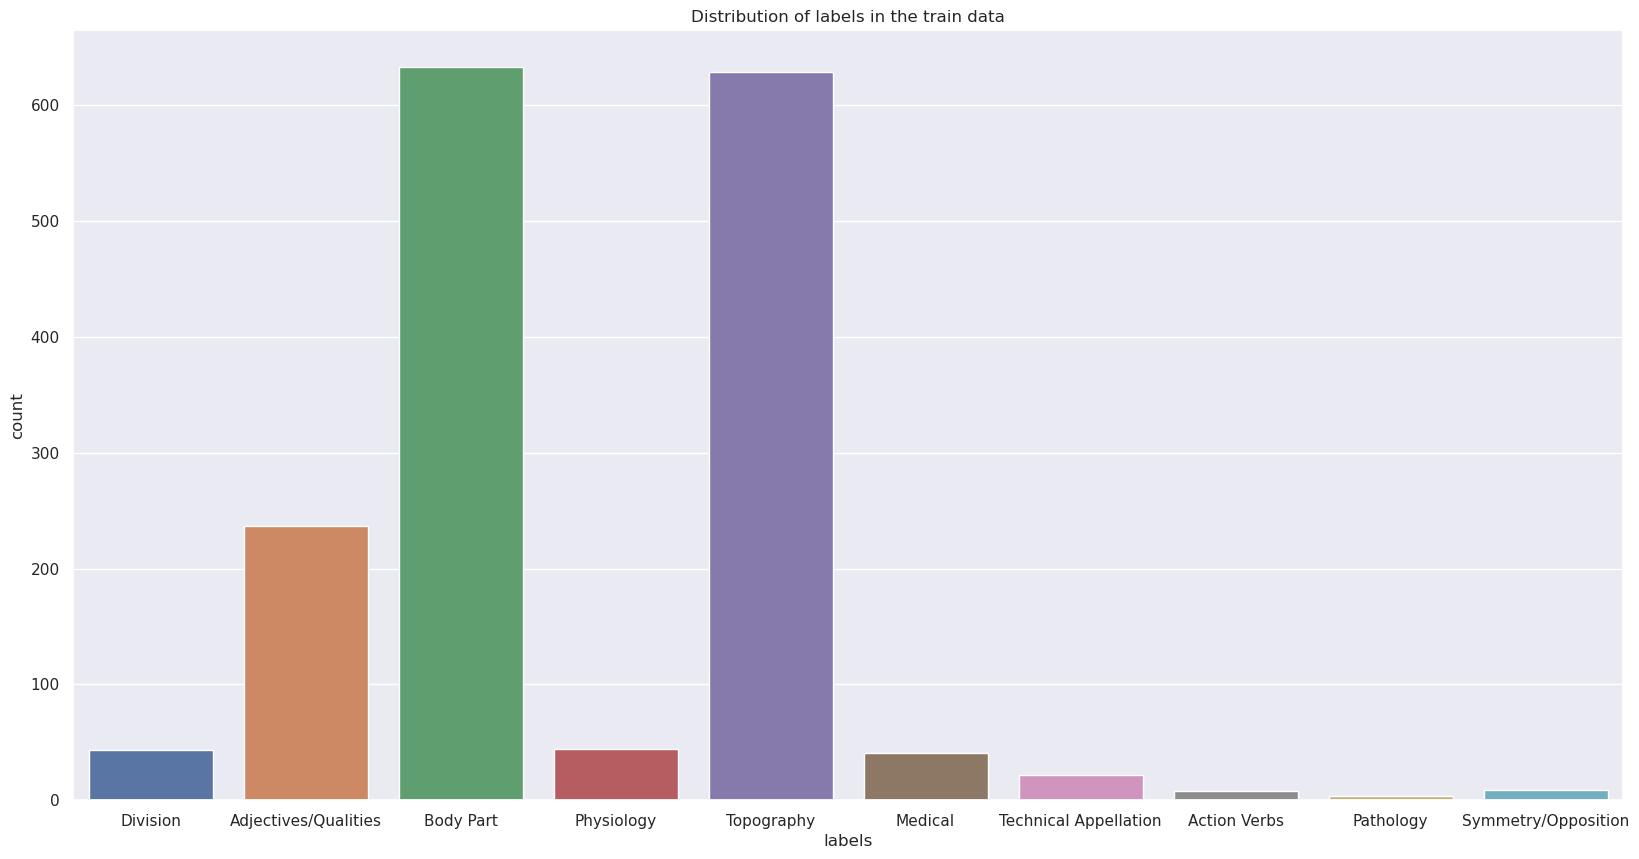

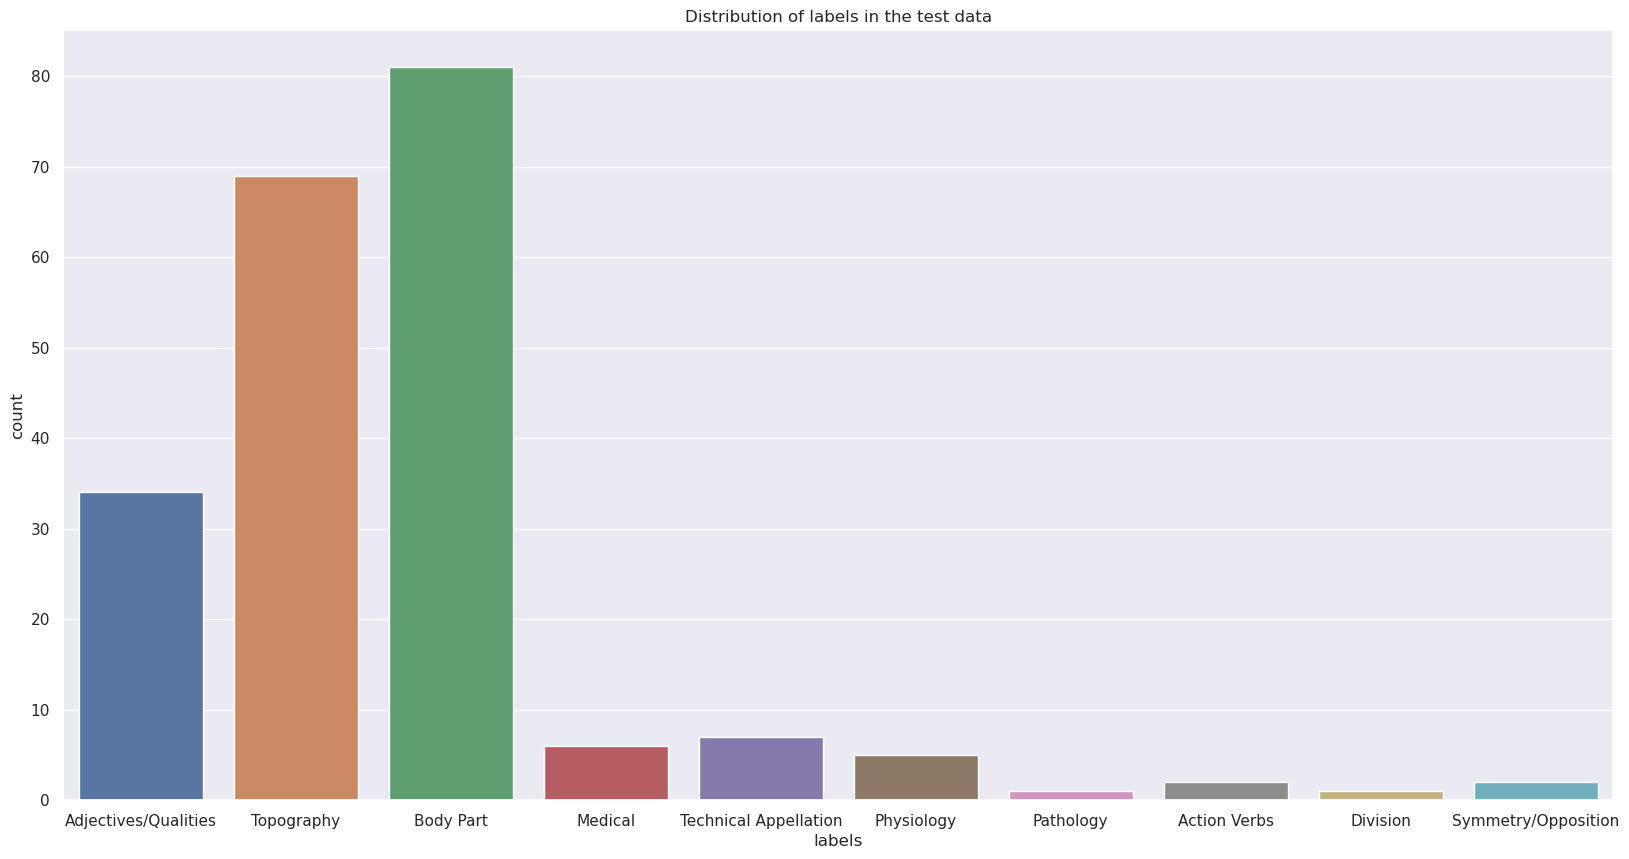

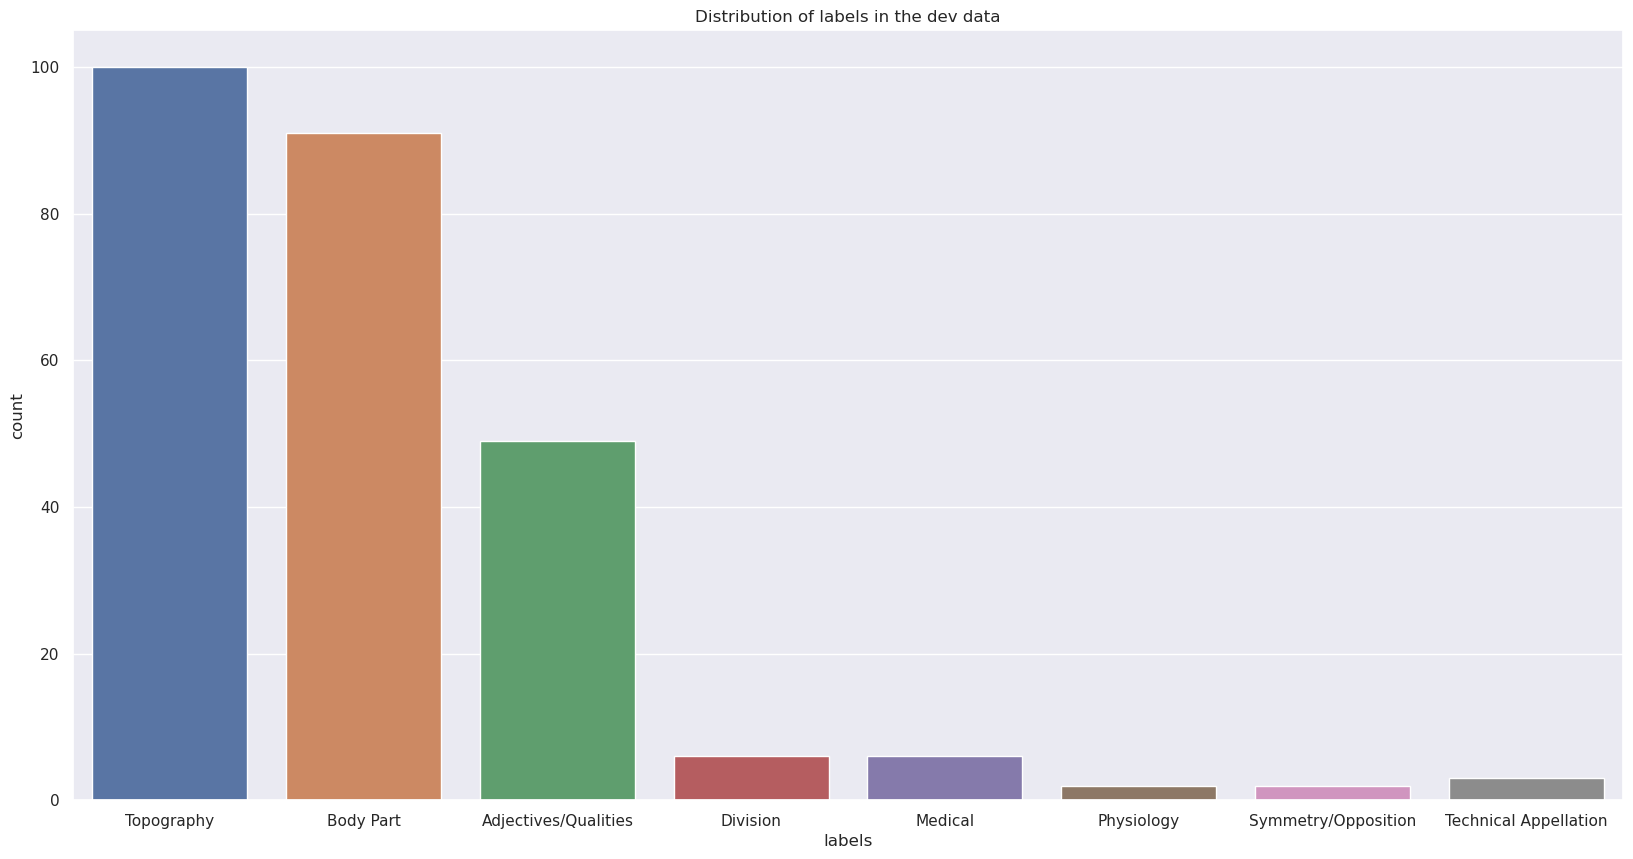

In [56]:
# visualize the distribution of the labels in the train, test and dev data
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="darkgrid")
plt.figure(figsize=(20,10))
train_data_labels = ([ent.label_ for docs in X_train for ent in docs.ents])
test_data_labels = ([ent.label_ for docs in X_test for ent in docs.ents])
dev_data_labels = ([ent.label_ for docs in X_dev for ent in docs.ents])
train_data_labels = pd.DataFrame(train_data_labels, columns=['labels'])
test_data_labels = pd.DataFrame(test_data_labels, columns=['labels'])
dev_data_labels = pd.DataFrame(dev_data_labels, columns=['labels'])
sns.countplot(data=train_data_labels, x='labels')
plt.title("Distribution of labels in the train data")
plt.figure(figsize=(20,10))
sns.countplot(data=test_data_labels, x='labels')
plt.title("Distribution of labels in the test data")
plt.figure(figsize=(20,10))
sns.countplot(data=dev_data_labels, x='labels')
plt.title("Distribution of labels in the dev data")

<Axes: xlabel='labels', ylabel='count'>

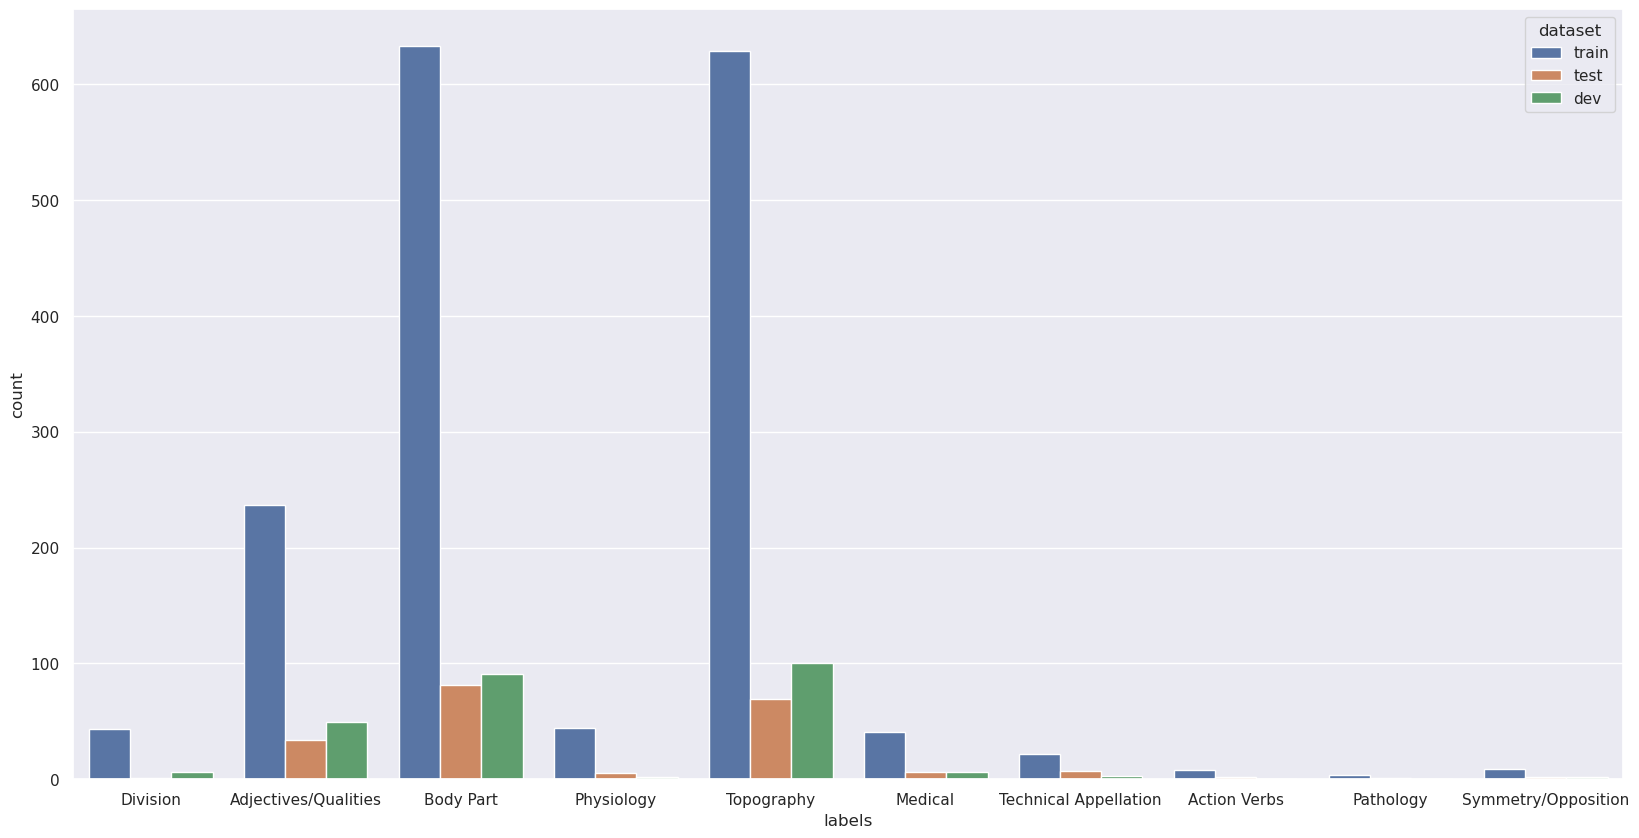

In [57]:
# check distribution of classes in train and test set with respect to each other
import pandas as pd
train_data_labels = ([ent.label_ for docs in X_train for ent in docs.ents])
test_data_labels = ([ent.label_ for docs in X_test for ent in docs.ents])
dev_data_labels = ([ent.label_ for docs in X_dev for ent in docs.ents])
train_data_labels = pd.DataFrame(train_data_labels, columns=['labels'])
test_data_labels = pd.DataFrame(test_data_labels, columns=['labels'])
dev_data_labels = pd.DataFrame(dev_data_labels, columns=['labels'])
train_data_labels['dataset'] = 'train'
test_data_labels['dataset'] = 'test'
dev_data_labels['dataset'] = 'dev'
all_data_labels = pd.concat([train_data_labels, test_data_labels, dev_data_labels], ignore_index=True)
plt.figure(figsize=(20,10))
sns.countplot(data=all_data_labels, x='labels', hue='dataset')



(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Body Part'),
  Text(1, 0, 'Topography'),
  Text(2, 0, 'Adjectives/Qualities'),
  Text(3, 0, 'Physiology'),
  Text(4, 0, 'Division'),
  Text(5, 0, 'Medical'),
  Text(6, 0, 'Technical Appellation'),
  Text(7, 0, 'Symmetry/Opposition'),
  Text(8, 0, 'Action Verbs'),
  Text(9, 0, 'Pathology')])

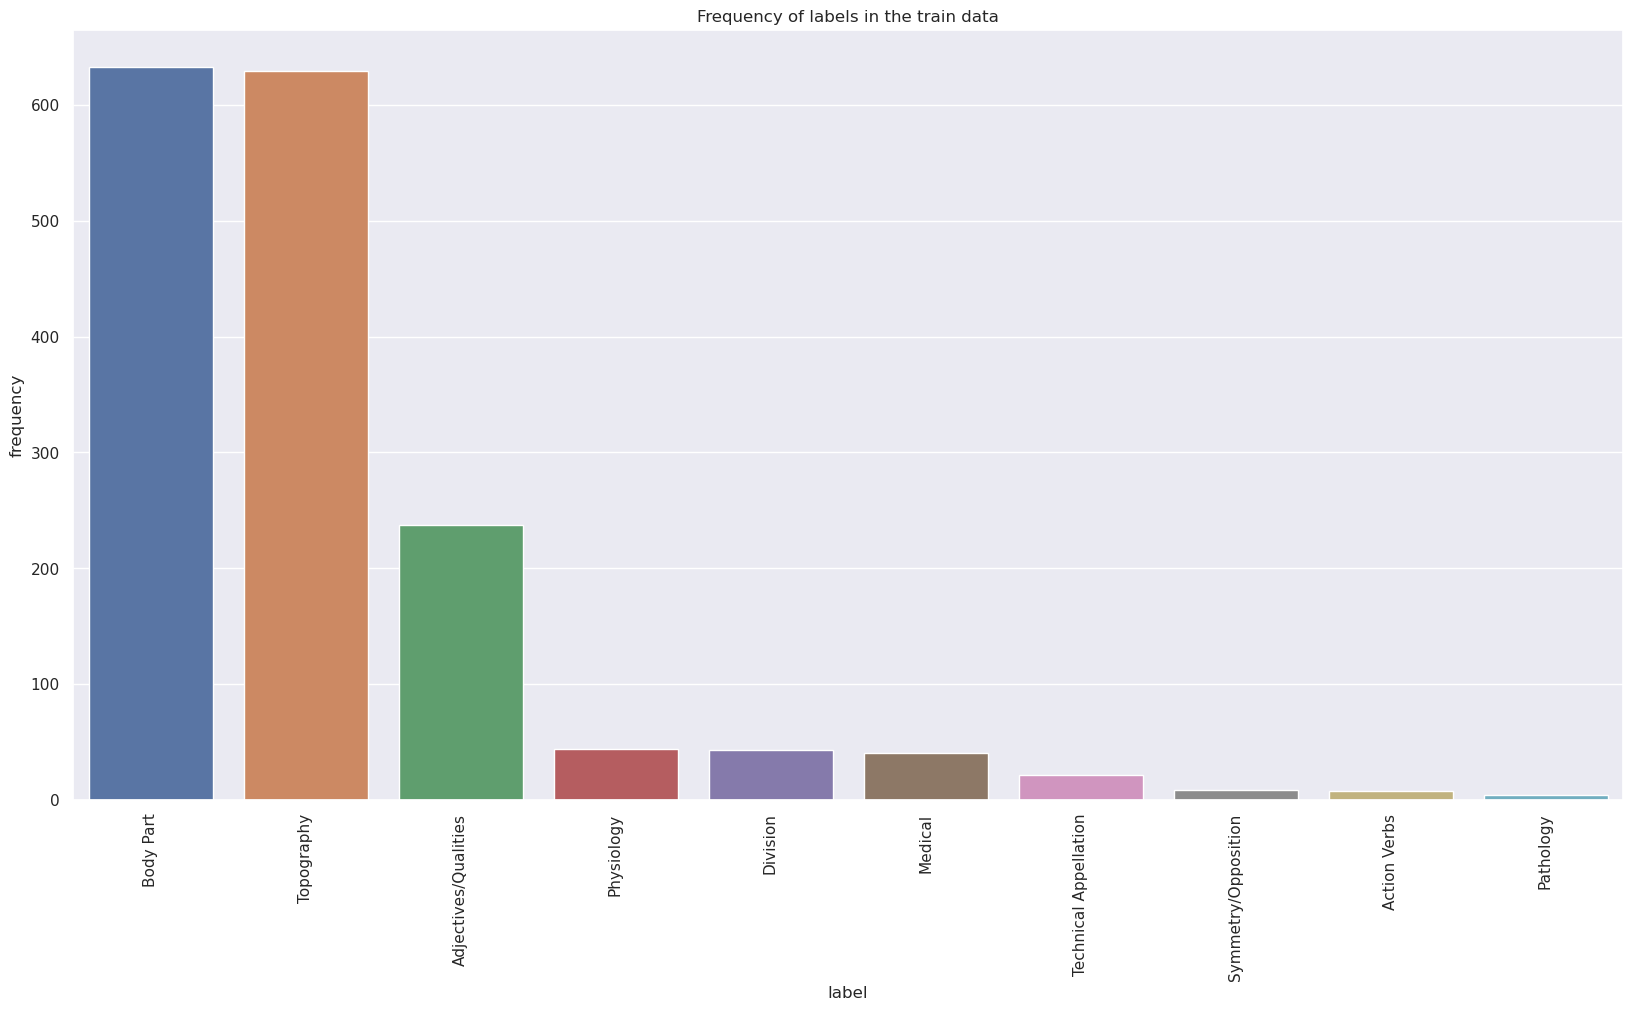

In [59]:
# visualize frequency of annotation labels in X_train set
train_data_labels = ([ent.label_ for docs in X_train for ent in docs.ents])
train_data_labels = pd.DataFrame(train_data_labels, columns=['labels'])
train_data_labels = train_data_labels['labels'].value_counts()
train_data_labels = pd.DataFrame(train_data_labels)
train_data_labels = train_data_labels.reset_index()
train_data_labels = train_data_labels.rename(columns={'index': 'label', 'labels': 'frequency'})
plt.figure(figsize=(20,10))
sns.barplot(data=train_data_labels, x='label', y='frequency')
plt.title("Frequency of labels in the train data")
plt.xticks(rotation=90)

In [53]:
print ("test:", len(X_test), "dev:", len(X_dev), "train:", len(X_train))


test: 36 dev: 35 train: 280


# Imported Dataset evaluation
(i.e. not the dataset created during the script run)

In [3]:
import spacy
from spacy.tokens import DocBin, doc

In [6]:
nlp = spacy.load("../training/transformer_mostfiles/NER/model-best")

In [8]:
# load the train and test data to disk
train_docbin = DocBin().from_disk("../corpus/train/ner_train/ner_train.spacy")
X_train = list(train_docbin.get_docs(nlp.vocab))
dev_docbin = DocBin().from_disk("../corpus/dev/ner_dev/ner_dev.spacy")
X_dev = list(dev_docbin.get_docs(nlp.vocab))
test_docbin = DocBin().from_disk("../corpus/test/ner_test/ner_test.spacy")
X_test = list(test_docbin.get_docs(nlp.vocab))


In [ ]:
# check distribution of classes in train and test set with respect to each other
import pandas as pd
train_data_labels = ([ent.label_ for docs in X_train for ent in docs.ents])
test_data_labels = ([ent.label_ for docs in X_test for ent in docs.ents])
dev_data_labels = ([ent.label_ for docs in X_dev for ent in docs.ents])
train_data_labels = pd.DataFrame(train_data_labels, columns=['labels'])
test_data_labels = pd.DataFrame(test_data_labels, columns=['labels'])
dev_data_labels = pd.DataFrame(dev_data_labels, columns=['labels'])
train_data_labels['dataset'] = 'train'
test_data_labels['dataset'] = 'test'
dev_data_labels['dataset'] = 'dev'
all_data_labels = pd.concat([train_data_labels, test_data_labels, dev_data_labels], ignore_index=True)
plt.figure(figsize=(20,10))
sns.countplot(data=all_data_labels, x='labels', hue='dataset')

In [12]:
# show distribution in numbers
all_data_labels.groupby(['labels', 'dataset']).size()
print(all_data_labels.groupby(['labels', 'dataset']).size())

labels                 dataset
Action Verbs           test         2
                       train        8
Adjectives/Qualities   dev         49
                       test        34
                       train      237
Body Part              dev         91
                       test        81
                       train      633
Division               dev          6
                       test         1
                       train       43
Medical                dev          6
                       test         6
                       train       41
Pathology              test         1
                       train        4
Physiology             dev          2
                       test         5
                       train       44
Symmetry/Opposition    dev          2
                       test         2
                       train        9
Technical Appellation  dev          3
                       test         7
                       train       22
Topography         

Congratulations. You have prepared your dataset for training. The files are saved in the Corpus folder.